# 概述
这是一个牛刀小试的项目，相对简单的开胃菜。  
项目的目的是在提供的图片中识别出车道线，并用蓝色线条描绘标注。（实际生活中需处理视频，事实上也是把视频流转换为一帧又一帧的图）  
# 项目流程
前面的几个函数是展示处理后图片的函数，运行中想展示哪一步的图像都可以调用这三个函数展示图像。  
先是载入图片、高斯滤波、灰度处理、边缘检测（Canny）、找ROI区域这几步对图像进行初步处理，得到更容易通过特征提取得到结果的图像。  
然后需要通过霍夫变换找出图中的直线（所以该项目存在缺陷，难以识别曲线的车道，以后我会设法改进）、画出直线、过滤掉差别大的点、找线的端点，最后在原图上进行图像合成叠加（把画车道的图和原图叠加），将最终得到的结果图像存储在./result_img/test.jpg中。  
代码和运行结果如下，为了更好地展示每一步的操作结果，这部分代码在代码文件中代码的基础上添加了一些plt的方法展示几个关键步骤得到的图像。

最终结果如下：


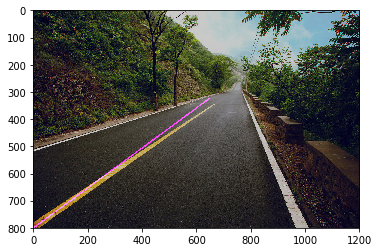

重要步骤得到的图片展示：


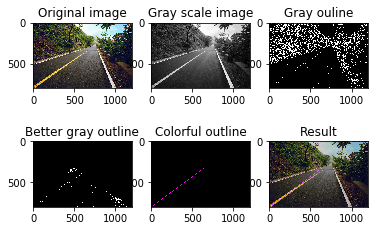

In [3]:
'''
项目的目的是在提供的图片中识别出车道线，并用蓝色线条描绘标注
前面的几个函数是展示处理后图片的函数，运行中想展示哪一步的图像都可以调用这三个函数展示图像
先是载入图片、高斯滤波、灰度处理、边缘检测（Canny）、找ROI区域这几步对图像进行初步处理，
得到更容易通过特征提取得到结果的图像
然后需要通过霍夫变换找出图中的直线（所以该项目存在缺陷，难以识别曲线的车道，以后我会设法改进）、
画出直线、过滤掉差别大的点、找线的端点，最后在原图上进行图像合成叠加（把画车道的图和原图叠加），
将最终得到的结果图像存储在./result_img/test.jpg中
'''

#导入需要的工具包
import cv2
import numpy as np
from matplotlib import pyplot as plt

#显示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

#展示彩色图片
def plt_show0(img):
    plt.imshow(img[:,:,[2,1,0]])
    plt.show()
    
#展示灰度图片
def plt_show1(img):
    plt.imshow(img, cmap = 'gray')
    plt.show()


#读图
raw_img = cv2.imread('img.jpg')

#高斯滤波降噪
gaussian = cv2.GaussianBlur(raw_img, (3,3), 0, 0)

#转化为灰度图
img=cv2.cvtColor(gaussian, cv2.COLOR_BGR2GRAY)

#边缘检测
lthreshlod = 50
hthreshold = 150
canny = cv2.Canny(img, lthreshlod, hthreshold)

#找到ROI区域，并把非ROI区域变成黑色
regin = np.array([[(0,img.shape[0]), (460,325), (520,325), (img.shape[1],img.shape[0])]])
mask = np.zeros_like(canny)
mask_color = 255
cv2.fillPoly(mask, regin, mask_color)
roi = cv2.bitwise_and(canny, mask)

#霍夫变换找直线
rho = 1
theta = np.pi/180
threshold = 15
minlength = 40
maxlengthgap = 20
lines = cv2.HoughLinesP(roi, rho, theta, threshold, np.array([]), minlength, maxlengthgap)

#画出直线
linecolor = [255, 0, 255]
linewideth = 3
roi1 = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)
lefts = []
rights = []
for item in lines:
    for x1, y1, x2, y2 in item:
        #区分左右车道
        k = (y2-y1)/(x2-x1)
        if k < 0:
            lefts.append(item)
        else:
            rights.append(item)

#过滤斜率差别大的点
def choose_lines(lines, threshold):
    slope = [(y2-y1)/(x2-x1) for item in lines for x1, x2, y1, y2 in item]
    while len(lines) > 0:
        mean = np.mean(slope)
        diff = [abs(s-mean) for s in slope]
        idx = np.argmax(diff)
        if diff[idx] > threshold:
            slope.pop(idx)
            lines.pop(idx)
        else:
            break

    return lines

#找一条线的端点
def clac_edgepoints(points, ymin, ymax):
    x = [p[0] for p in points]
    y = [p[1] for p in points]

    k = np.polyfit(y, x, 1)
    func = np.poly1d(k)

    xmin = int(func(ymin))
    xmax = int(func(ymax))

    return[(xmin, ymin),(xmax, ymax)]

#得到处理后的点
good_leftlines = choose_lines(lefts, 0.1)
good_rightlines = choose_lines(rights, 0.1)

left_points = [(x1, y1) for left in good_leftlines for x1, y1, x2, y2 in left]
left_points = left_points + [(x2, y2) for left in good_leftlines for x1, y1, x2, y2 in left]
right_points = [(x1, y1) for right in good_leftlines for x1, y1, x2, y2 in right]
right_points = right_points + [(x2, y2) for right in good_leftlines for x1, y1, x2, y2 in right]

#画左右车道线的端点
lefttop = clac_edgepoints(left_points, 325, img.shape[0])
righttop = clac_edgepoints(right_points, 325, img.shape[0])

roi2 = np.zeros_like(roi1)  

cv2.line(roi2, lefttop[0], lefttop[1], linecolor, linewideth)
cv2.line(roi2, righttop[0], righttop[1], linecolor, linewideth)

#在图上画出车道线（图像的合成叠加）
image = cv2.addWeighted(raw_img, 0.8, roi2, 1, 0)
#存储和展示图片
cv2.imwrite('./result_img/test.jpg', image)

print('最终结果如下：')
plt_show0(image)

print('重要步骤得到的图片展示：')
plt.subplot(231),plt.imshow(raw_img[:,:,[2,1,0]]),plt.title('Original image')
plt.subplot(232),plt.imshow(img, cmap = 'gray'),plt.title('Gray scale image')
plt.subplot(233),plt.imshow(canny, cmap = 'gray'),plt.title('Gray ouline')
plt.subplot(234),plt.imshow(roi, cmap = 'gray'),plt.title('Better gray outline')
plt.subplot(235),plt.imshow(roi2[:,:,[2,1,0]]),plt.title('Colorful outline')
plt.subplot(236),plt.imshow(image[:,:,[2,1,0]]),plt.title('Result')
plt.show()